In [1444]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1445]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# %matplotlib inline

In [1446]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [1447]:
%pip install researchpy

Note: you may need to restart the kernel to use updated packages.


# Pricey PCs
For this project I am going to build a regression model to predict PC prices based on the hardware specifications

Importing dataset from google drive into google colab

In [1448]:
# # Let google colab access google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [1449]:
# #read data into dataframe from google drive
# pc_df = pd.read_csv('/content/drive/MyDrive/Singapore Poly/Year 2/AIML/AIML-ST1511-CA1/pc_data (regression).csv')

Importing dataset into Jupyter notebook

In [1450]:
#read factory data into dataframe
pc_df = pd.read_csv("pc_data (regression).csv")

# Initial Summary
Insights from .info() and .head():
1. There are 12 features including target feature `Price ($)` and 15320 rows
2. No missing values at all
3. Only 2 features are of float datatype (continuous data)
4. Data Cleaning/Feature Engineering needs to be done to make EDA process easier (such as making `Weight` feature continuous, splitting `Hard Disk` feature to Disk Type and Storage Space, etc.)


In [1451]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


In [1452]:
pc_df.head()

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


# Feature Engineering
Before further doing EDA, Feature Engineering is done to break down the dataset so that it is better for EDA

For this Feature Engineering process, there is no need to do train test split as I am only splitting string values and changing datatypes of some features so there would be no data leakage 


### 1) Drop `Product ID`

In [1453]:
pc_df = pc_df.drop(['Product ID'], axis=1) # Drop entire column from DataFrame
pc_df.columns

Index(['Brand', 'Type', 'Screen Size', 'Screen Specs', 'CPU', 'RAM',
       'Hard Disk', 'GPU', 'Operating System', 'Weight', 'Price ($)'],
      dtype='object')

### 2) `Weight` feature

Remove kg 

In [1454]:
pc_df['Weight'] = pd.to_numeric(pc_df['Weight'].str.replace('kg', '')) # Remove kg and make dtype numeric
pc_df = pc_df.rename(columns = {'Weight':'Weight (kg)'}) # Change column header Weight => Weight (kg)

pc_df.dtypes

Brand                object
Type                 object
Screen Size         float64
Screen Specs         object
CPU                  object
RAM                  object
Hard Disk            object
GPU                  object
Operating System     object
Weight (kg)         float64
Price ($)           float64
dtype: object

In [1455]:
# Checking that Weight column has changed
pc_df[['Weight (kg)']].head()

,Weight (kg)
0,1.37
1,1.34
2,1.86
3,1.83
4,1.37


### 3) `Hard Disk` feature
Create 4 seperate columns for SSD, Hybrid, HDD and Flash Storage

In [1456]:
pc_df['Hard Disk'].unique() # Look at unique values for Hard Disk feature

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [1457]:
# There are 2 disks for some PCs so we split into primary disk and secondary disk features by splitting at '+' sign
pc_df[['Hard Disk','Extra Disk']] = pc_df["Hard Disk"].str.split("+", 1, expand=True)

# Remove whitespaces at start and end of every value
pc_df['Hard Disk'] = pc_df['Hard Disk'].str.strip()
pc_df['Extra Disk'] = pc_df['Extra Disk'].str.strip()

pc_df = pc_df.fillna(value=np.nan) # Replace None with NaN

pc_df[['Hard Disk', 'Extra Disk']].head()

,Hard Disk,Extra Disk
0,128GB SSD,NaN
1,128GB Flash Storage,NaN
2,256GB SSD,NaN
3,512GB SSD,NaN
4,256GB SSD,NaN


In [1458]:
# Hard Disk: Split into Hard Disk Type and Hard Disk Storage, then drop Hard Disk feature
pc_df[['Hard Disk Storage','Hard Disk Type']] = pc_df["Hard Disk"].str.split(" ", 1, expand=True)
pc_df = pc_df.drop(['Hard Disk'], axis=1)

# Extra Disk: Split into Extra Disk Type and Extra Disk Storage, then drop Extra Disk feature
pc_df[['Extra Disk Storage','Extra Disk Type']] = pc_df["Extra Disk"].str.split(" ", 1, expand=True)
pc_df = pc_df.drop(['Extra Disk'], axis=1)

pc_df[['Hard Disk Storage', 'Hard Disk Type', 'Extra Disk Storage', 'Extra Disk Type']].head() # Check that new columns have been created

,Hard Disk Storage,Hard Disk Type,Extra Disk Storage,Extra Disk Type
0,128GB,SSD,NaN,NaN
1,128GB,Flash Storage,NaN,NaN
2,256GB,SSD,NaN,NaN
3,512GB,SSD,NaN,NaN
4,256GB,SSD,NaN,NaN


In [1459]:
# Hard Disk: Change 1.0TB to 1TB
pc_df.loc[(pc_df['Hard Disk Storage'] == '1.0TB'),'Hard Disk Storage']='1TB'

# Extra Disk: Change 1.0TB to 1TB
pc_df.loc[(pc_df['Extra Disk Storage'] == '1.0TB'),'Extra Disk Storage']='1TB'

# Hard Disk: Change 1TB = 1000GB and 2TB = 2000GB
pc_df.loc[(pc_df['Hard Disk Storage'] == '1TB'),'Hard Disk Storage']='1000GB'
pc_df.loc[(pc_df['Hard Disk Storage'] == '2TB'),'Hard Disk Storage']='2000GB'

# Extra Disk: Change 1TB = 1000GB and 2TB = 2000GB
pc_df.loc[(pc_df['Extra Disk Storage'] == '1TB'),'Extra Disk Storage']='1000GB'
pc_df.loc[(pc_df['Extra Disk Storage'] == '2TB'),'Extra Disk Storage']='2000GB'

print(pc_df['Hard Disk Storage'].unique())
print(pc_df['Extra Disk Storage'].unique())

['128GB' '256GB' '512GB' '500GB' '1000GB' '32GB' '64GB' '2000GB' '16GB'
 '180GB' '240GB' '8GB' '508GB']
[nan '1000GB' '256GB' '2000GB' '500GB' '512GB']


In [1460]:
pc_df['Hard Disk Storage'] = pd.to_numeric(pc_df['Hard Disk Storage'].str.replace('GB', '')) # Remove GB and make dtype numeric
pc_df = pc_df.rename(columns = {'Hard Disk Storage':'Hard Disk GB'}) # Change column header Hard Disk Storage => Hard Disk (GB)

pc_df['Extra Disk Storage'] = pd.to_numeric(pc_df['Extra Disk Storage'].str.replace('GB', '')) # Remove GB and make dtype numeric
pc_df = pc_df.rename(columns = {'Extra Disk Storage':'Extra Disk GB'}) # Change column header Extra Disk Storage => Extra Disk (GB)

In [1461]:
#split main disk and extra disk into 2 dataframes
harddisks = pc_df[['Hard Disk GB','Hard Disk Type']]
extradisks = pc_df[['Extra Disk GB', 'Extra Disk Type']]

In [1462]:
# use pivot table to make disk type the column name
harddisk = harddisks.pivot_table(values='Hard Disk GB', index=harddisks.index, columns='Hard Disk Type', aggfunc='first')

extradisks = extradisks.fillna(value=0) #pivot table drops rows where values are all NaN, so fill with a dummy value to keep the rows
extradisk = extradisks.pivot_table(values='Extra Disk GB', index=extradisks.index, columns='Extra Disk Type', aggfunc='first')
extradisk = extradisk.drop(columns=[0])

print(harddisk.shape)
print(extradisk.shape)

(15320, 4)
(15320, 3)


In [1463]:
harddisk.head()

Hard Disk Type,Flash Storage,HDD,Hybrid,SSD
0,NaN,NaN,NaN,128.0
1,128.0,NaN,NaN,NaN
2,NaN,NaN,NaN,256.0
3,NaN,NaN,NaN,512.0
4,NaN,NaN,NaN,256.0


In [1464]:
extradisk.head()

Extra Disk Type,HDD,Hybrid,SSD
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [1465]:
disks_combi = harddisk.add(extradisk, fill_value=0)

disks_combi.shape

(15320, 4)

In [1466]:
disks_combi.head()

,Flash Storage,HDD,Hybrid,SSD
0,NaN,NaN,NaN,128.0
1,128.0,NaN,NaN,NaN
2,NaN,NaN,NaN,256.0
3,NaN,NaN,NaN,512.0
4,NaN,NaN,NaN,256.0


In [1467]:
pc_df = pc_df.drop(columns=['Hard Disk GB', 'Hard Disk Type', 'Extra Disk GB', 'Extra Disk Type'])

pc_df = pd.concat([pc_df, disks_combi], axis=1)

pc_df = pc_df.fillna(value=0)

In [1468]:
pc_df.head()

,Brand,Type,Screen Size,Screen Specs,CPU,RAM,GPU,Operating System,Weight (kg),Price ($),Flash Storage,HDD,Hybrid,SSD
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,0.0,0.0,0.0,128.0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,Intel HD Graphics 6000,macOS,1.34,2394.77616,128.0,0.0,0.0,0.0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics 620,No OS,1.86,1531.80000,0.0,0.0,0.0,256.0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,AMD Radeon Pro 455,macOS,1.83,6759.76680,0.0,0.0,0.0,512.0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,0.0,0.0,0.0,256.0


### 4) `Screen Specs` feature
Seperate into touchscreen, screen specs, screen resolution, and remove the namings for screen resolution 

In [1469]:
pc_df['Screen Specs'].value_counts() # Look at all unique values for Screen Specs feature

Full HD 1920x1080                                5944
1366x768                                         3304
IPS Panel Full HD 1920x1080                      2728
IPS Panel Full HD / Touchscreen 1920x1080         632
Full HD / Touchscreen 1920x1080                   556
1600x900                                          276
Touchscreen 1366x768                              192
Quad HD+ / Touchscreen 3200x1800                  180
IPS Panel 4K Ultra HD 3840x2160                   144
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     132
4K Ultra HD / Touchscreen 3840x2160               120
4K Ultra HD 3840x2160                              84
IPS Panel 1366x768                                 84
Touchscreen 2560x1440                              84
IPS Panel Quad HD+ / Touchscreen 3200x1800         72
Touchscreen 2256x1504                              68
IPS Panel Retina Display 2304x1440                 68
IPS Panel Touchscreen 2560x1440                    60
IPS Panel Retina Display 256

In [1470]:
pc_df['Screen Res'] = pc_df['Screen Specs'].str.extract(r'(\d+x\d+)') # Get screen resolution using regex
pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'(\d+x\d+)', '', regex=True) # Remove screen resolution from Screen Specs
pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'^\s*$', np.nan, regex=True) # Replace blank spaces with NaN in Screen Specs

pc_df[['Screen Specs', 'Screen Res']].head() # Make sure it is extracted correctly

,Screen Specs,Screen Res
0,IPS Panel Retina Display,2560x1600
1,NaN,1440x900
2,Full HD,1920x1080
3,IPS Panel Retina Display,2880x1800
4,IPS Panel Retina Display,2560x1600


In [1471]:
pc_df['Screen Specs'].value_counts() # Look at all unique values for Screen Specs feature

Full HD                                 5944
IPS Panel Full HD                       2788
IPS Panel Full HD / Touchscreen          632
Full HD / Touchscreen                    556
Touchscreen                              380
Quad HD+ / Touchscreen                   180
IPS Panel Retina Display                 168
IPS Panel Touchscreen                    152
IPS Panel 4K Ultra HD                    144
IPS Panel 4K Ultra HD / Touchscreen      132
IPS Panel                                132
4K Ultra HD / Touchscreen                120
4K Ultra HD                               84
IPS Panel Quad HD+ / Touchscreen          72
IPS Panel Quad HD+                        60
Quad HD+                                  36
IPS Panel Touchscreen / 4K Ultra HD       24
Touchscreen / Full HD                     12
Touchscreen / 4K Ultra HD                 12
Touchscreen / Quad HD+                     8
Name: Screen Specs, dtype: int64

In [1472]:
# Remove Full HD, Quad HD, Quad HD+, 4K Ultra HD from the column values as it is just the industry name for the specific screen resolution
# Also remove '/' symbol 
pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'(Full HD|Quad HD|4K Ultra HD|\+|/)', '', regex=True)
pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'^\s*$', np.nan, regex=True) # Replace blank spaces with NaN

pc_df['Screen Specs'].unique() # Look at all unique values for Screen Specs feature 

array(['IPS Panel Retina Display ', nan, 'IPS Panel  ',
       'IPS Panel   Touchscreen ', '  Touchscreen ', 'Touchscreen   ',
       'IPS Panel Touchscreen ', 'Touchscreen ', 'IPS Panel ',
       'IPS Panel Touchscreen   '], dtype=object)

In [1473]:
# Create new feature to show if the PC is Touchscreen
pc_df['Touchscreen'] = pc_df['Screen Specs'].str.extract(r'(Touchscreen)') # Extract Touchscreen keyword to new column
pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'(Touchscreen)','',regex=True) # Remove Touchscreen keyword from original column

pc_df["Touchscreen"] = np.where(pc_df["Touchscreen"] == "Touchscreen", "Yes", "No") # Encode Touchscreen column

pc_df['Screen Specs'] = pc_df['Screen Specs'].replace(r'^\s*$', np.nan, regex=True) # Replace blank spaces with NaN

pc_df.head() # Make sure the column is created properly

,Brand,Type,Screen Size,Screen Specs,CPU,RAM,GPU,Operating System,Weight (kg),Price ($),Flash Storage,HDD,Hybrid,SSD,Screen Res,Touchscreen
0,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5 2.3GHz,8GB,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,0.0,0.0,0.0,128.0,2560x1600,No
1,Apple,Ultrabook,13.3,NaN,Intel Core i5 1.8GHz,8GB,Intel HD Graphics 6000,macOS,1.34,2394.77616,128.0,0.0,0.0,0.0,1440x900,No
2,HP,Notebook,15.6,NaN,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics 620,No OS,1.86,1531.80000,0.0,0.0,0.0,256.0,1920x1080,No
3,Apple,Ultrabook,15.4,IPS Panel Retina Display,Intel Core i7 2.7GHz,16GB,AMD Radeon Pro 455,macOS,1.83,6759.76680,0.0,0.0,0.0,512.0,2880x1800,No
4,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5 3.1GHz,8GB,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,0.0,0.0,0.0,256.0,2560x1600,No


In [1474]:
# Remove whitespace for all values in Screen Specs feature
pc_df['Screen Specs'] = pc_df['Screen Specs'].str.strip()

pc_df['Screen Specs'].unique() # Show Screen Specs column values

array(['IPS Panel Retina Display', nan, 'IPS Panel'], dtype=object)

In [1475]:
# Screen Specs feature are Missing Not At Random, fill with None string as we are going to do further preprocessing and do not want any NaNs
pc_df['Screen Specs'] = pc_df['Screen Specs'].fillna(value='None')

### 5) `CPU` feature
Extract Brand

In [1476]:
pc_df['CPU'].value_counts() # Look at values of CPU feature

Intel Core i5 7200U 2.5GHz     2240
Intel Core i7 7700HQ 2.8GHz    1732
Intel Core i7 7500U 2.7GHz     1604
Intel Core i7 8550U 1.8GHz      836
Intel Core i5 8250U 1.6GHz      820
                               ... 
Intel Core i5 2.0GHz              8
Intel Core i7 2.9GHz              8
AMD E-Series E2-6110 1.5GHz       8
Intel Core i7 2.7GHz              8
Intel Atom x5-Z8300 1.44GHz       8
Name: CPU, Length: 118, dtype: int64

In [1477]:
# Check unique CPU brands
cpu_df = pc_df["CPU"].str.split(" ", 1, expand=True)
print(cpu_df[0].unique())
cpu_df.head()

['Intel' 'AMD' 'Samsung']


,0,1
0,Intel,Core i5 2.3GHz
1,Intel,Core i5 1.8GHz
2,Intel,Core i5 7200U 2.5GHz
3,Intel,Core i7 2.7GHz
4,Intel,Core i5 3.1GHz


In [1478]:
# Seperating CPU Clock Speed feature
pc_df['CPU Clock Speed (GHz)'] = pc_df['CPU'].str.split().str[-1] # Extract CPU clock speed to new column
pc_df['CPU Clock Speed (GHz)'] = pd.to_numeric(pc_df['CPU Clock Speed (GHz)'].str.replace('GHz', '')) # Remove GHz and make dtype numeric
pc_df['CPU'] = pc_df["CPU"].str.rsplit(' ',1).str[0] # Remove clock speed from original column

# Seperate CPU Brands
pc_df['CPU Brand'] = pc_df['CPU'].str.extract(r'(Intel|AMD|Samsung)') # Extract CPU brands to new column

pc_df[['CPU', 'CPU Clock Speed (GHz)', 'CPU Brand']].head() # Make sure new columns are created

,CPU,CPU Clock Speed (GHz),CPU Brand
0,Intel Core i5,2.3,Intel
1,Intel Core i5,1.8,Intel
2,Intel Core i5 7200U,2.5,Intel
3,Intel Core i7,2.7,Intel
4,Intel Core i5,3.1,Intel


### 6) `GPU` feature
Extract Brand

In [1479]:
# Check unique GPU brands
gpu_df = pc_df["GPU"].str.split(" ", 1, expand=True)
print(gpu_df[0].unique())
gpu_df.head()

['Intel' 'AMD' 'Nvidia' 'ARM']


,0,1
0,Intel,Iris Plus Graphics 640
1,Intel,HD Graphics 6000
2,Intel,HD Graphics 620
3,AMD,Radeon Pro 455
4,Intel,Iris Plus Graphics 650


In [1480]:
pc_df['GPU Brand'] = pc_df['GPU'].str.extract(r'(Intel|AMD|Nvidia|ARM)') # Extract GPU Brand from GPU feature
pc_df[['GPU', 'GPU Brand']].head() # Make sure new column is created

,GPU,GPU Brand
0,Intel Iris Plus Graphics 640,Intel
1,Intel HD Graphics 6000,Intel
2,Intel HD Graphics 620,Intel
3,AMD Radeon Pro 455,AMD
4,Intel Iris Plus Graphics 650,Intel


### 7) RAM feature
Change into numeric

In [1481]:
pc_df['RAM'] = pd.to_numeric(pc_df['RAM'].str.replace('GB', '')) # Remove GB and make dtype numeric
pc_df = pc_df.rename(columns = {'RAM':'RAM (GB)'}) # Change column header Weight => RAM (GB)

pc_df.dtypes

Brand                     object
Type                      object
Screen Size              float64
Screen Specs              object
CPU                       object
RAM (GB)                   int64
GPU                       object
Operating System          object
Weight (kg)              float64
Price ($)                float64
Flash Storage            float64
HDD                      float64
Hybrid                   float64
SSD                      float64
Screen Res                object
Touchscreen               object
CPU Clock Speed (GHz)    float64
CPU Brand                 object
GPU Brand                 object
dtype: object

### 8) New feature: Pixels Per Inch (PPI)
To calculate PPI:
1. diagonal in pixels = sqrt(width * width + height * height)
2. ppi = diagonal in pixels / diagonal in inches

Pixels per inch (PPI) measures pixel density/resolution of a computer screen. It indicates how many pixels are in a one inch line on a display

The higher the PPI, the better the display quality of the screen

In [1482]:
# split Screen Res column to width and height
screenres_df = pc_df["Screen Res"].str.split("x", 1, expand=True)
screenres_df = screenres_df.rename(columns={0: "width", 1: "height"})

# convert datatype of width and height to numeric
screenres_df['width'] = pd.to_numeric(screenres_df['width'])
screenres_df['height'] = pd.to_numeric(screenres_df['height'])

screenres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   width   15320 non-null  int64
 1   height  15320 non-null  int64
dtypes: int64(2)
memory usage: 239.5 KB


In [1483]:
# calculate ppi using the formula
ppi = pd.DataFrame(np.sqrt(np.square(screenres_df['width']) + np.square(screenres_df['height'])) / pc_df['Screen Size'])
ppi = ppi.rename(columns={0: "ppi"})

ppi.head()

,ppi
0,226.983005
1,127.677940
2,141.211998
3,220.534624
4,226.983005


In [1484]:
#drop Screen Res to avoid high collinearity between this column and ppi
pc_df = pc_df.drop(['Screen Res'], axis=1)

# concatenate ppi column to dataframe
pc_df = pd.concat([pc_df, ppi], axis=1)

In [1485]:
pc_df.head()

,Brand,Type,Screen Size,Screen Specs,CPU,RAM (GB),GPU,Operating System,Weight (kg),Price ($),Flash Storage,HDD,Hybrid,SSD,Touchscreen,CPU Clock Speed (GHz),CPU Brand,GPU Brand,ppi
0,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,0.0,0.0,0.0,128.0,No,2.3,Intel,Intel,226.983005
1,Apple,Ultrabook,13.3,None,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,128.0,0.0,0.0,0.0,No,1.8,Intel,Intel,127.677940
2,HP,Notebook,15.6,None,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,1531.80000,0.0,0.0,0.0,256.0,No,2.5,Intel,Intel,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,0.0,0.0,0.0,512.0,No,2.7,Intel,AMD,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,0.0,0.0,0.0,256.0,No,3.1,Intel,Intel,226.983005


## Final dataset for EDA
Look at the changed dataset to make sure everything is okay

In [1486]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brand                  15320 non-null  object 
 1   Type                   15320 non-null  object 
 2   Screen Size            15320 non-null  float64
 3   Screen Specs           15320 non-null  object 
 4   CPU                    15320 non-null  object 
 5   RAM (GB)               15320 non-null  int64  
 6   GPU                    15320 non-null  object 
 7   Operating System       15320 non-null  object 
 8   Weight (kg)            15320 non-null  float64
 9   Price ($)              15320 non-null  float64
 10  Flash Storage          15320 non-null  float64
 11  HDD                    15320 non-null  float64
 12  Hybrid                 15320 non-null  float64
 13  SSD                    15320 non-null  float64
 14  Touchscreen            15320 non-null  object 
 15  CP

In [1487]:
pc_df.head()

,Brand,Type,Screen Size,Screen Specs,CPU,RAM (GB),GPU,Operating System,Weight (kg),Price ($),Flash Storage,HDD,Hybrid,SSD,Touchscreen,CPU Clock Speed (GHz),CPU Brand,GPU Brand,ppi
0,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,0.0,0.0,0.0,128.0,No,2.3,Intel,Intel,226.983005
1,Apple,Ultrabook,13.3,None,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,128.0,0.0,0.0,0.0,No,1.8,Intel,Intel,127.677940
2,HP,Notebook,15.6,None,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,1531.80000,0.0,0.0,0.0,256.0,No,2.5,Intel,Intel,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,0.0,0.0,0.0,512.0,No,2.7,Intel,AMD,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,0.0,0.0,0.0,256.0,No,3.1,Intel,Intel,226.983005


# Exploratory Data Analysis
Deepen understanding on this dataset using visualisations and numerical summaries.

## EDA Summary

1. 12 out of 19 features in this dataset are of categorical datatype
2. There is high cardinality (many unique values) in `CPU` and `GPU`
4. Distribution of target feature `Price ($)` is positively skewed

CPU/GPU Brands Boxplot:
1. There are distinct median prices for each GPU and CPU Brand. PCs with Intel CPU and Nvidia GPU have a higher median price
2. The positive skew of `Price ($)` affects CPU and GPU of all brands, except ARM GPUs and Samsung CPUs
3. The furthermost tail of `Price ($)` distribution are mostly equipped Nvidia GPUs and Intel CPUs



## Bivariate Boxplot: Price by CPU and GPU Brands

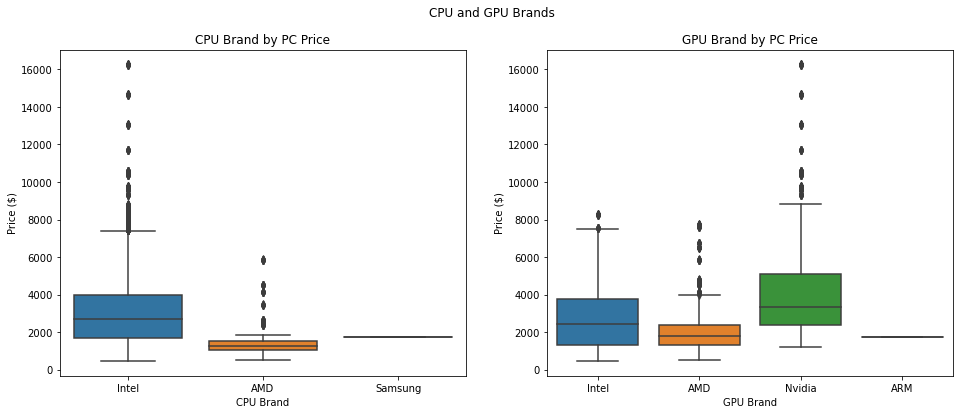

In [1491]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CPU and GPU Brands')

sns.boxplot(ax=axes[0], x="CPU Brand", y="Price ($)", data=pc_df)
axes[0].set_title('CPU Brand by PC Price')

sns.boxplot(ax=axes[1], x="GPU Brand", y="Price ($)", data=pc_df)
axes[1].set_title('GPU Brand by PC Price')

plt.show()

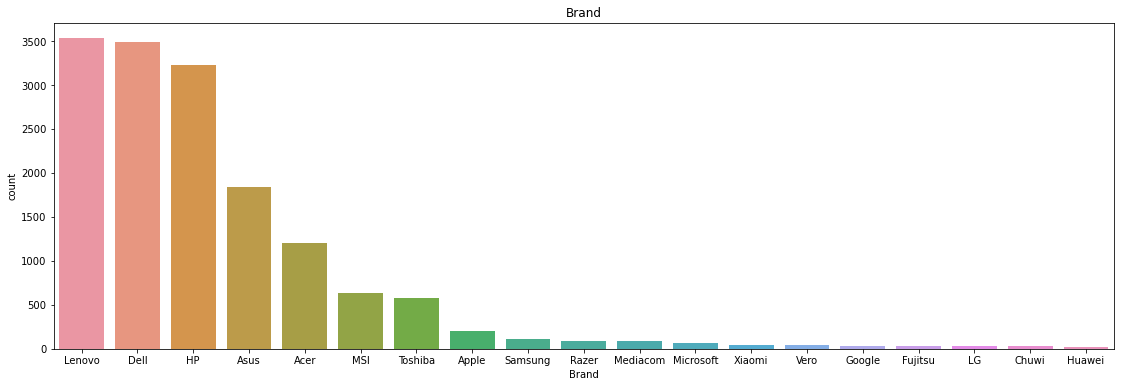

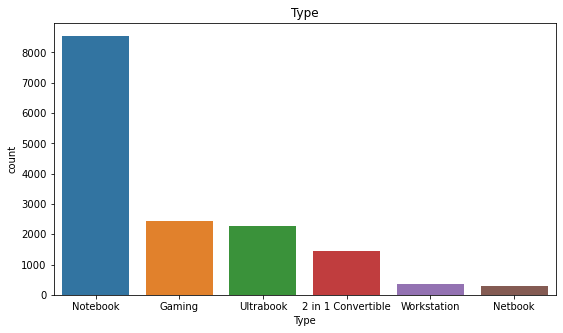

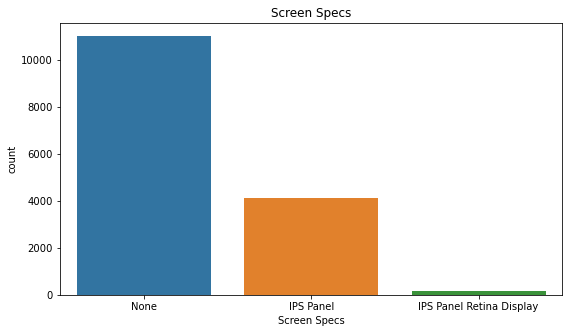

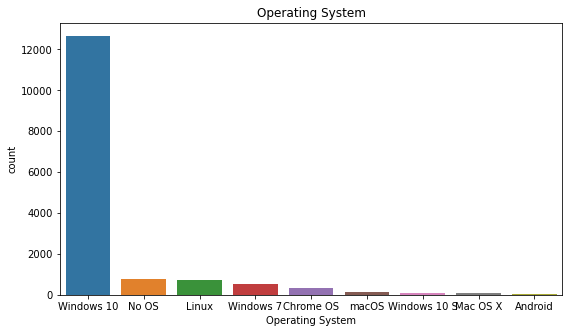

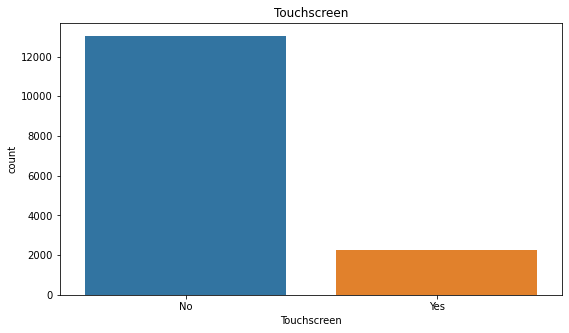

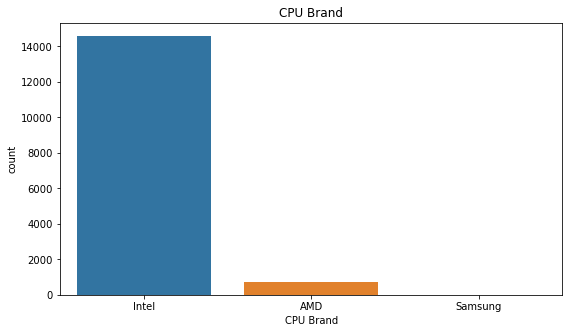

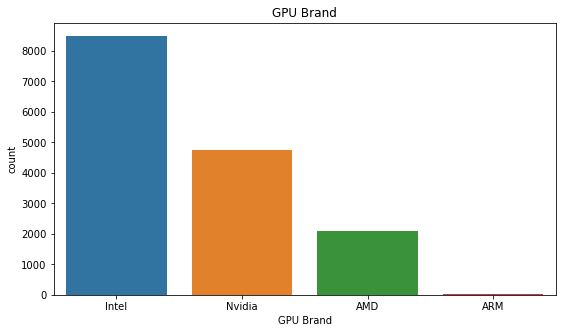

In [1492]:
feature_list = list(pc_df.select_dtypes('O'))


for feature in feature_list:
    if feature not in ['CPU', 'GPU']: # leave out CPU and GPU to plot seperately
        data = pc_df[feature]
        
        if feature == 'Brand': # set figsize
            plt.figure(figsize=(19, 6))
        else:
            plt.figure(figsize=(9, 5))
        
        sns.countplot(x=data, order=data.value_counts().index).set_title(feature)

plt.show()

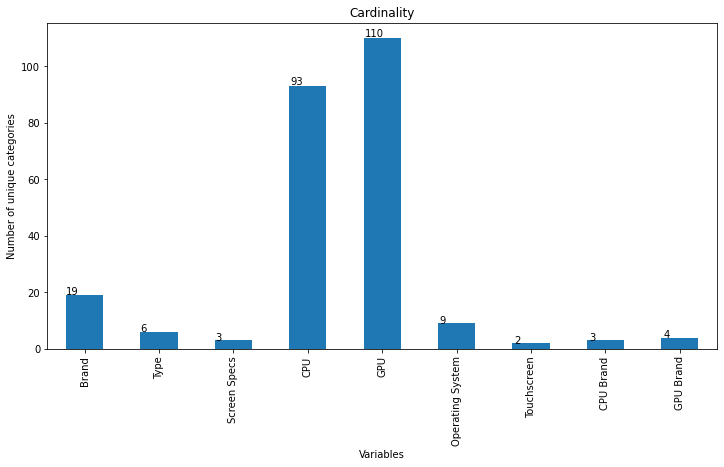

In [1493]:
ax = pc_df.select_dtypes('O').nunique().plot.bar(figsize=(12,6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

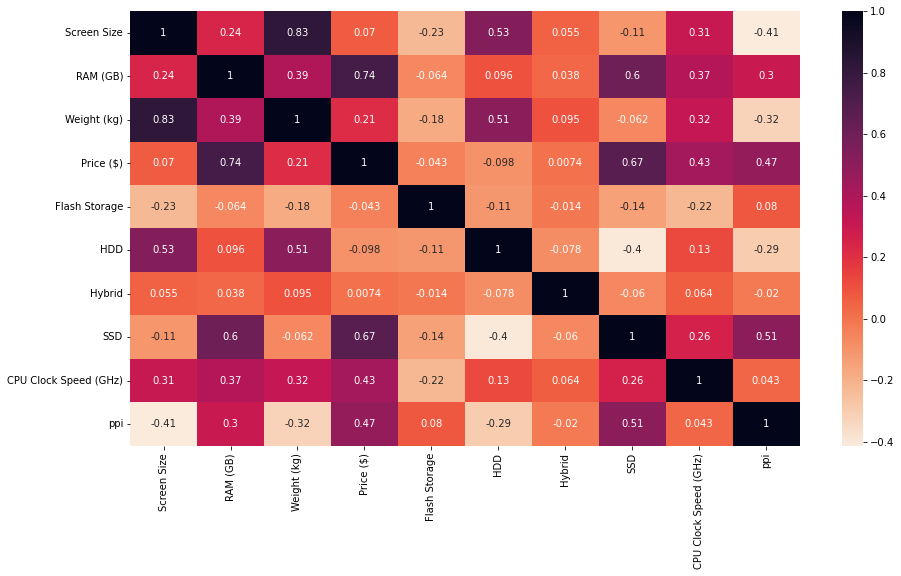

In [1494]:
feature_list = list(pc_df.select_dtypes(exclude=['O']))

plt.figure(figsize=(15,8)) 
sns.heatmap(pc_df[feature_list].corr(), annot=True, cmap='rocket_r')

plt.show

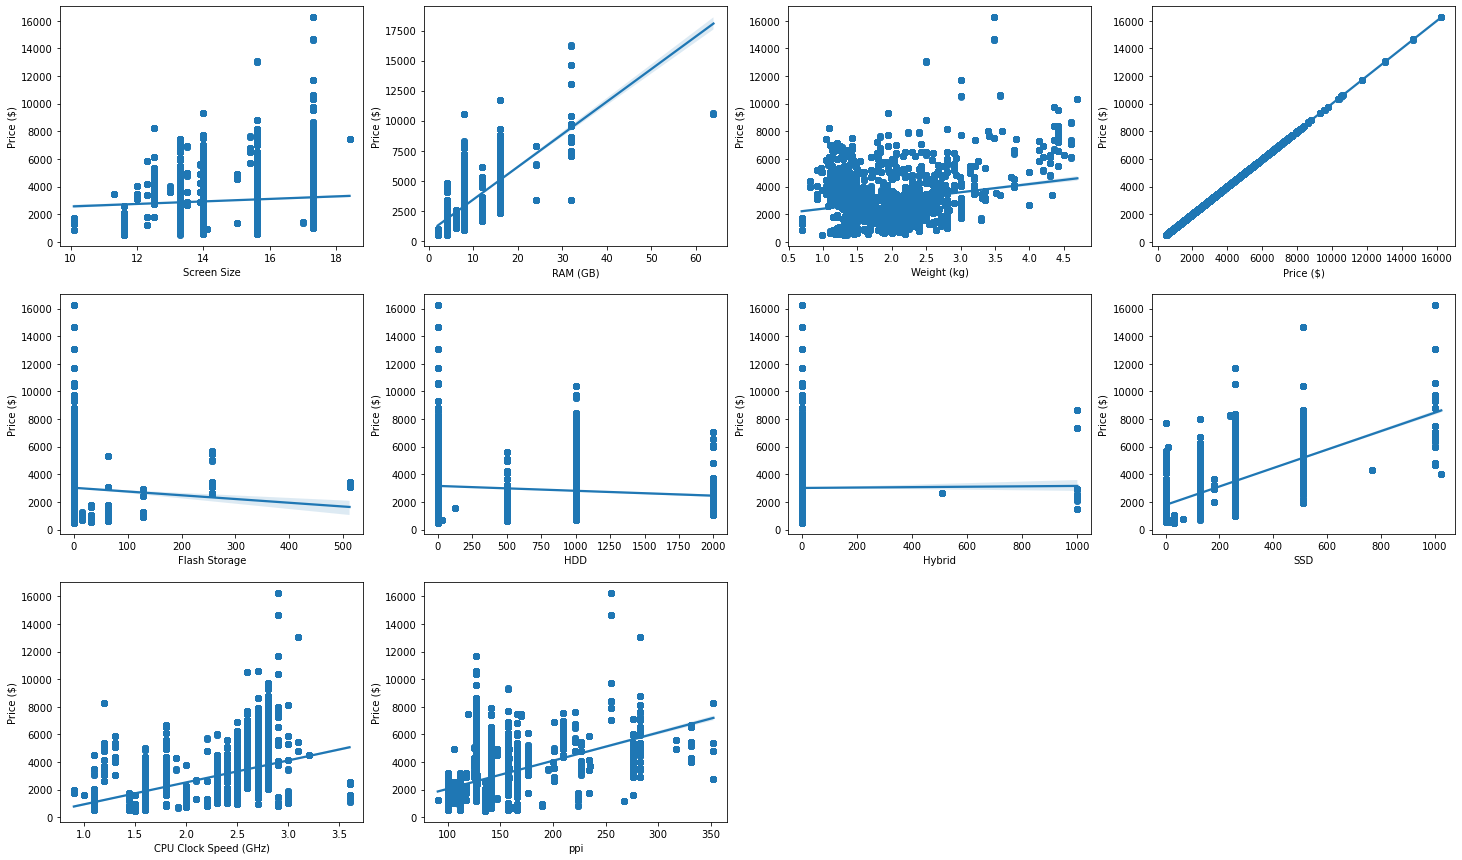

In [1495]:
feature_list = list(pc_df.select_dtypes(exclude=['O']))

fig = plt.figure(figsize = (25, 15))
i = 0

for feature in feature_list:
  sub = fig.add_subplot(3, 4, i + 1)
  sns.regplot(x=feature, y="Price ($)", data=pc_df)
  i += 1

plt.show()

# Feature Engineering (Part 2)
Preparing the dataset for ML modelling

1. In `Operating System` feature, rename all different types of Windows OS as "Windows", all different types of Mac OS as "Mac".

2. A positively skewed target feature can affect how regression model fits the data points as it has many outliers. This can affect the equation of the regression model and cause it to make bad predictions. A log transformation on `Price ($)` can be done to make the data assume near normal distribution

In [1496]:
import researchpy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

## 1) `Operating System` feature

In [1497]:
# Unique values in Operating System feature before grouping the OS
pc_df['Operating System'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [1498]:
# Group all different Windows OS as the same value. Same for all Mac OS
replace_os = {'Windows 10':'Windows', 'Windows 10 S':'Windows', 'Windows 7':'Windows', 'macOS':'Mac', 'Mac OS X':'Mac'}

pc_df['Operating System'] = pc_df['Operating System'].replace(replace_os)

pc_df['Operating System'].unique()

array(['Mac', 'No OS', 'Windows', 'Linux', 'Android', 'Chrome OS'],
      dtype=object)

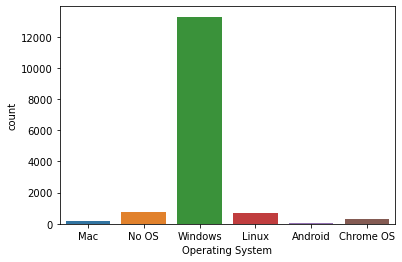

In [1499]:
sns.countplot(x=pc_df['Operating System'])
plt.show()

## 2) Log Transformation on `Price`
Train test split is not required as log transform simply performs log function on every value in the dataset, the output will not be affected by the values/nature of the dataset

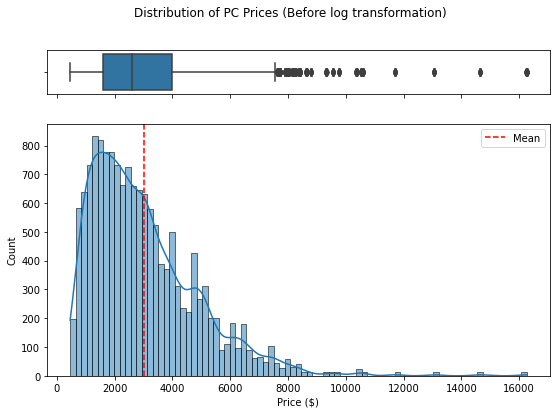

In [1500]:
# boxplot and histplot together
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (9, 6))
sns.boxplot(x="Price ($)", data=pc_df, ax=ax_box)
sns.histplot(x="Price ($)",data=pc_df, ax=ax_hist, kde=True)

# find mean value
mean = pc_df['Price ($)'].mean()

# create mean line on histogram 
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")

ax_hist.legend()
ax_box.set(xlabel='')
fig.suptitle('Distribution of PC Prices (Before log transformation)')

plt.show()

In [1501]:
# log transform Price ($) feature
pc_df['Price ($)'] = np.log(pc_df['Price ($)'])

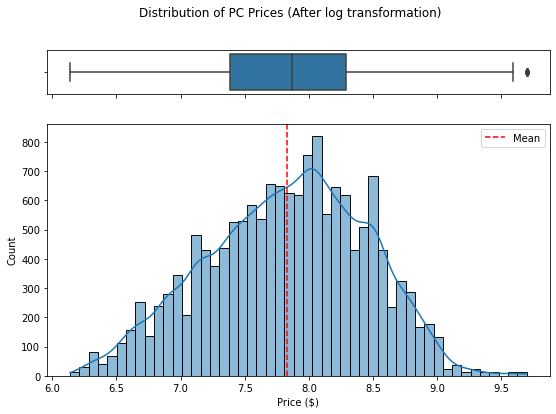

In [1502]:
# boxplot and histplot together
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (9, 6))
sns.boxplot(x="Price ($)", data=pc_df, ax=ax_box)
sns.histplot(x="Price ($)",data=pc_df, ax=ax_hist, kde=True)

# find mean value
mean = pc_df['Price ($)'].mean()

# create mean line on histogram 
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")

ax_hist.legend()
ax_box.set(xlabel='')
fig.suptitle('Distribution of PC Prices (After log transformation)')

plt.show()

## 3) Train Test Split

In [1503]:
X = pc_df.drop(['Price ($)'], axis = 1)
y = pc_df['Price ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reset index for x_train and x_test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# reset index for y_train and y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## 4) Multicollinearity between nominal variables

Cramer's V Test for multicollinearity between nominal variables:
1. Use to determine the strength of association between 2 nominal variables with more than 2 categories.
2. It is used after Chi-Square Test proved that there is association between the 2 variables
3. From the heatmap, there are a number of variables that have strong correlation with each other

According to the Cramer's V score heatmap (based on training dataset):
1. GPU and GPU brand have score of 1 = perfect association
2. CPU and CPU brand have score of 1 = perfect association
3. Type and Touchscreen have a score of 0.78 = strong association

Dropping columns:
1. Since GPU and CPU columns have very high cardinality and are also strongly associated with GPU brand and CPU brand, drop GPU and CPU
2. Whether the PC is Touchscreen or not may depend on the Type of PC, hence Type is the independent variable here, so we drop Touchscreen column


In [1504]:
X_train.select_dtypes('O').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Brand             12256 non-null  object
 1   Type              12256 non-null  object
 2   Screen Specs      12256 non-null  object
 3   CPU               12256 non-null  object
 4   GPU               12256 non-null  object
 5   Operating System  12256 non-null  object
 6   Touchscreen       12256 non-null  object
 7   CPU Brand         12256 non-null  object
 8   GPU Brand         12256 non-null  object
dtypes: object(9)
memory usage: 861.9+ KB


In [1505]:
nominal_df = X_train[['Brand', 'Type', 'Screen Specs', 'CPU', 'GPU', 'Operating System', 'Touchscreen', 'CPU Brand', 'GPU Brand']]
nominal_df_cols = ['Brand', 'Type', 'Screen Specs', 'CPU', 'GPU', 'Operating System', 'Touchscreen', 'CPU Brand', 'GPU Brand']
nominal_df.columns = range(nominal_df.shape[1]) # change column name to numeric increasing integer

In [1506]:
from itertools import combinations
combos = list(combinations(nominal_df.columns, 2))

feature_pvals = []
for combi in combos:
    crosstab, result = researchpy.crosstab(nominal_df[combi[0]], nominal_df[combi[1]], test="chi-square")
    feature_pvals.append([nominal_df_cols[combi[0]], nominal_df_cols[combi[1]], result.iloc[1,1], result.iloc[2,1]])

pd.DataFrame(np.array(feature_pvals), columns = ['variable_1', 'variable_2', 'p-value', 'cramer_v']).sort_values('cramer_v', ascending=False)

,variable_1,variable_2,p-value,cramer_v
24,CPU,CPU Brand,0.0,1.0
29,GPU,GPU Brand,0.0,1.0
28,GPU,CPU Brand,0.0,0.9348
35,CPU Brand,GPU Brand,0.0,0.81
25,CPU,GPU Brand,0.0,0.807
12,Type,Touchscreen,0.0,0.7777
10,Type,GPU,0.0,0.6863
15,Screen Specs,CPU,0.0,0.6861
22,CPU,Operating System,0.0,0.6511
1,Brand,Screen Specs,0.0,0.641


In [1507]:
# loop through all combinations and calculate cramer's v score
pvals_cramerv = []
for col in nominal_df:
  for col2 in nominal_df:
    crosstab, result = researchpy.crosstab(nominal_df[col], nominal_df[col2], test="chi-square")
    pvals_cramerv.append([nominal_df_cols[col], nominal_df_cols[col2], result.iloc[2, 1]])

pvals_cramerv_array = pd.DataFrame(np.array(pvals_cramerv), columns = ['variable_1', 'variable_2', 'cramer_v'])

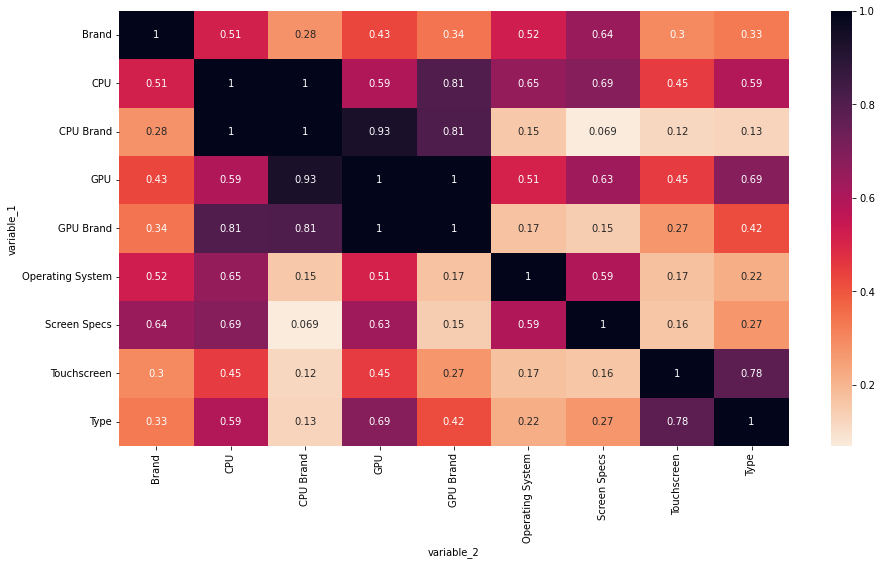

In [1508]:
plt.figure(figsize=(15,8))
cramerv_matrix = pvals_cramerv_array.pivot(index="variable_1", columns="variable_2", values="cramer_v")

for col in cramerv_matrix: # change datatype of all columns to numeric
  cramerv_matrix[col] = pd.to_numeric(cramerv_matrix[col])

sns.heatmap(cramerv_matrix, annot=True, cmap='rocket_r')

plt.show()

In [1509]:
crosstab, result = researchpy.crosstab(X_train['CPU Brand'], X_train['GPU Brand'], test="chi-square")

crosstab

GPU Brand                        
GPU Brand       AMD ARM Intel Nvidia    All
CPU Brand                                  
AMD             576   0     0      0    576
Intel          1096   0  6816   3757  11669
Samsung           0  11     0      0     11
All            1672  11  6816   3757  12256

In [1510]:
# Drop GPU, CPU and Touchscreen
X_train = X_train.drop(['GPU', 'CPU', 'CPU Brand'], axis=1)
X_test = X_test.drop(['GPU', 'CPU', 'CPU Brand'], axis=1)

print(f"X_train columns: {list(X_train.columns)}")
print(f"X_test columns: {list(X_test.columns)}")

X_train columns: ['Brand', 'Type', 'Screen Size', 'Screen Specs', 'RAM (GB)', 'Operating System', 'Weight (kg)', 'Flash Storage', 'HDD', 'Hybrid', 'SSD', 'Touchscreen', 'CPU Clock Speed (GHz)', 'GPU Brand', 'ppi']
X_test columns: ['Brand', 'Type', 'Screen Size', 'Screen Specs', 'RAM (GB)', 'Operating System', 'Weight (kg)', 'Flash Storage', 'HDD', 'Hybrid', 'SSD', 'Touchscreen', 'CPU Clock Speed (GHz)', 'GPU Brand', 'ppi']


## 5) Multicollinearity between numerical variables

VIF (Variance Inflation Factor) is used to detect multicollinearity between numerical variables. VIF determines correlation strength between variables by taking a variable and plotting a regression model against all other variables.

The benefit of using VIF is that VIF takes multivariate collinearity into account. When using other methods such as Pearson's correlation, only bivariate correlation can be seen

Pearson Correlation is also displayed in correlation heatmap to show bivariate correlation between variables

Insights:
1. From correlation heatmap scores, Screen Size is highly correlated with Weight at a score of 0.83
2. Screen Size also has the highest VIF among variables at 66.41, hence Screen Size is dropped

(All insights are based on training dataset)

In [1511]:
X_train.select_dtypes(exclude=['O']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Screen Size            12256 non-null  float64
 1   RAM (GB)               12256 non-null  int64  
 2   Weight (kg)            12256 non-null  float64
 3   Flash Storage          12256 non-null  float64
 4   HDD                    12256 non-null  float64
 5   Hybrid                 12256 non-null  float64
 6   SSD                    12256 non-null  float64
 7   CPU Clock Speed (GHz)  12256 non-null  float64
 8   ppi                    12256 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 861.9 KB


In [1512]:
# choose only numerical data from training dataset
numerical_data = X_train[['Screen Size', 'RAM (GB)', 'Weight (kg)', 'Flash Storage', 'HDD', 'Hybrid', 'SSD', 'CPU Clock Speed (GHz)', 'ppi']]

heatmap_data = pd.concat([X_train, y_train], axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

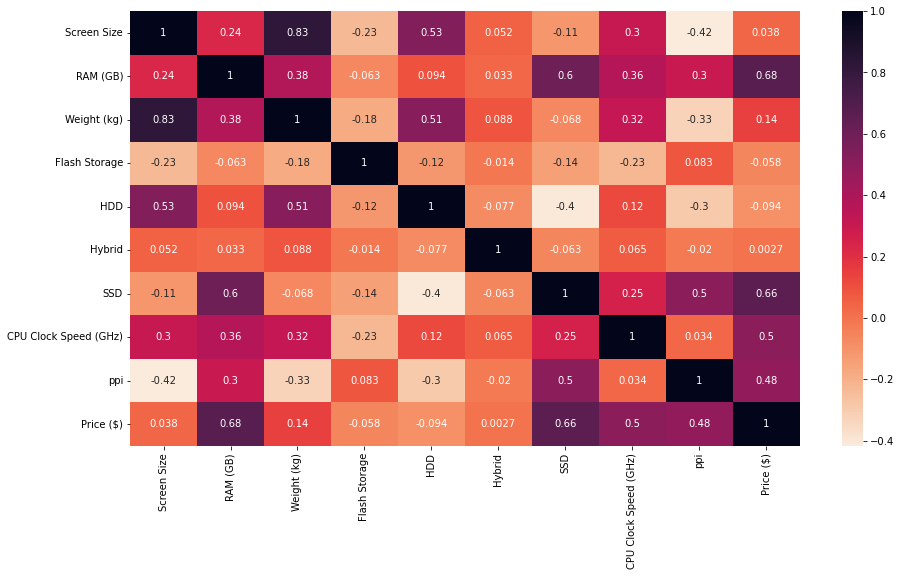

In [1513]:
plt.figure(figsize=(15,8)) 
sns.heatmap(heatmap_data.corr(), annot=True, cmap='rocket_r')

plt.show

In [1514]:
def vif_calc(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

vif_calc(numerical_data)

,variables,VIF
0,Screen Size,66.410563
1,RAM (GB),9.555751
2,Weight (kg),30.650716
3,Flash Storage,1.168355
4,HDD,3.115334
5,Hybrid,1.075008
6,SSD,5.749792
7,CPU Clock Speed (GHz),27.612514
8,ppi,16.366771


In [1515]:
# drop Screen Size
X_train = X_train.drop(['Screen Size'], axis=1)
X_test = X_test.drop(['Screen Size'], axis=1)

In [1516]:
# new vif scores
def vif_calc(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

numerical_data = X_train[['RAM (GB)', 'Weight (kg)', 'Flash Storage', 'HDD', 'Hybrid', 'SSD', 'CPU Clock Speed (GHz)', 'ppi']]

vif_calc(numerical_data) # scores went down by a lot after Screen Size was dropped
# Although some columns still have a score of above 10, we do not drop for now and will reevaluate our decision after modelling

,variables,VIF
0,RAM (GB),8.890992
1,Weight (kg),15.187743
2,Flash Storage,1.156830
3,HDD,3.115079
4,Hybrid,1.070046
5,SSD,5.733217
6,CPU Clock Speed (GHz),19.488171
7,ppi,10.959962


In [1517]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brand                  12256 non-null  object 
 1   Type                   12256 non-null  object 
 2   Screen Specs           12256 non-null  object 
 3   RAM (GB)               12256 non-null  int64  
 4   Operating System       12256 non-null  object 
 5   Weight (kg)            12256 non-null  float64
 6   Flash Storage          12256 non-null  float64
 7   HDD                    12256 non-null  float64
 8   Hybrid                 12256 non-null  float64
 9   SSD                    12256 non-null  float64
 10  Touchscreen            12256 non-null  object 
 11  CPU Clock Speed (GHz)  12256 non-null  float64
 12  GPU Brand              12256 non-null  object 
 13  ppi                    12256 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 1.3+ 

## 6) One Hot Encoding

In [1518]:
#get all nominal columns from training data into a dataframe
train_nominal_df = ['Brand', 'Type', 'Screen Specs', 'Operating System', 'Touchscreen', 'GPU Brand']

#get all nominal columns from testing data into a dataframe
test_nominal_df = ['Brand', 'Type', 'Screen Specs', 'Operating System', 'Touchscreen', 'GPU Brand']

In [1519]:
ohe = OneHotEncoder(drop='first') # instantiate OneHotEncoder object

# encode the training dataset
train_encoded = ohe.fit_transform(X_train[train_nominal_df])

# encode the test dataset
test_encoded = ohe.transform(X_test[test_nominal_df])

In [1520]:
# change encoded array into dataframe
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names())
test_encoded_df = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names())

print(train_encoded_df.shape)
print(test_encoded_df.shape)

(12256, 34)
(3064, 34)


In [1521]:
# combine encoded dataframe into training and testing datasets respectively

# drop categorical columns
X_train = X_train.drop(train_nominal_df, axis=1)
X_test = X_test.drop(test_nominal_df, axis=1)

# concatenate the new encoded categorical columns
X_train = pd.concat([X_train, train_encoded_df], axis=1)
X_test = pd.concat([X_test, test_encoded_df], axis=1)

In [1522]:
X_train.shape
X_train.head()

,RAM (GB),Weight (kg),Flash Storage,HDD,Hybrid,SSD,CPU Clock Speed (GHz),ppi,x0_Apple,x0_Asus,...,x2_None,x3_Chrome OS,x3_Linux,x3_Mac,x3_No OS,x3_Windows,x4_Yes,x5_ARM,x5_Intel,x5_Nvidia
0,6,2.80,0.0,1000.0,0.0,128.0,2.7,106.113062,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4,2.18,0.0,1000.0,0.0,0.0,2.5,141.211998,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,8,2.62,0.0,1000.0,0.0,128.0,2.8,282.423996,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,2.40,0.0,500.0,0.0,0.0,1.1,100.454670,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,8,1.88,0.0,0.0,0.0,256.0,2.5,141.211998,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [1523]:
X_test.shape
X_test.head()

,RAM (GB),Weight (kg),Flash Storage,HDD,Hybrid,SSD,CPU Clock Speed (GHz),ppi,x0_Apple,x0_Asus,...,x2_None,x3_Chrome OS,x3_Linux,x3_Mac,x3_No OS,x3_Windows,x4_Yes,x5_ARM,x5_Intel,x5_Nvidia
0,4,2.30,0.0,500.0,0.0,0.0,2.5,100.454670,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,16,3.78,0.0,1000.0,0.0,256.0,2.8,127.335675,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,4,3.00,0.0,1000.0,0.0,0.0,2.7,127.335675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,16,2.60,0.0,1000.0,0.0,128.0,2.8,141.211998,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,16,1.49,0.0,0.0,0.0,512.0,1.8,165.632118,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 7) Feature selection
Use Random Forest Regressor as an estimator in Recursive Feature Elimination to cut down number of features to use for modelling.

The final RFE recommended 37 features to use out of 43 features. However as shown in the CV scores by features selected graph, after 15 features, the decrease in negative Mean Squared Error is very small

I then used adjusted R^2 to compare between using the top 15 variables and using all 37 variables to see how much the additional 17 features contribute to the model's prediction using Random Forest Regressor as the model

Conclusion:
*   Looking at the adjusted R^2 values of both models, the adjusted R^2 of the model using all 37 features is 99.62%, while the other model achieved 99.58% using just the top 15 features
* Looking at the Mean Squared Error of both models, the model
*   The adjusted R^2 value only differed by around 0.04% with the extra 17 features, so I decided to keep only the top 15 features as I rather achieve a more intepretable model over the 0.04% increase in adjusted R^2 score.



In [1524]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV

In [1525]:
model = RandomForestRegressor(random_state=42)

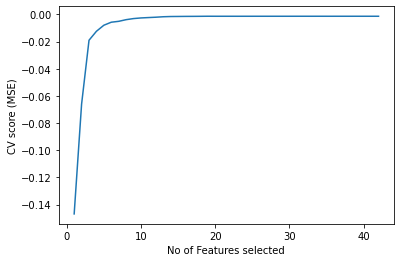

In [1526]:
min_features = 1

rfecv = RFECV(estimator=model, step=1, cv=3,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features
              )
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("No of Features selected")
plt.ylabel("CV score (MSE)")
plt.plot(range(min_features, len(rfecv.grid_scores_) + min_features), rfecv.grid_scores_)
plt.show()

In [1527]:
print("Number of features selected by RFE : %d" % rfecv.n_features_)

Number of features selected by RFE : 19


In [1528]:
# index X_train and X_test to only include the 37 selected features by RFE
X_train = X_train.loc[:,rfecv.ranking_==1]
X_test = X_test.loc[:, rfecv.ranking_==1]

In [1529]:
# Fit another RandomForestRegressor to find out the feature importances
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [1530]:
model.feature_names = X_train.columns

importance_df = pd.DataFrame({'feature_names': model.feature_names, 'importance': model.feature_importances_})

importance_df = importance_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)

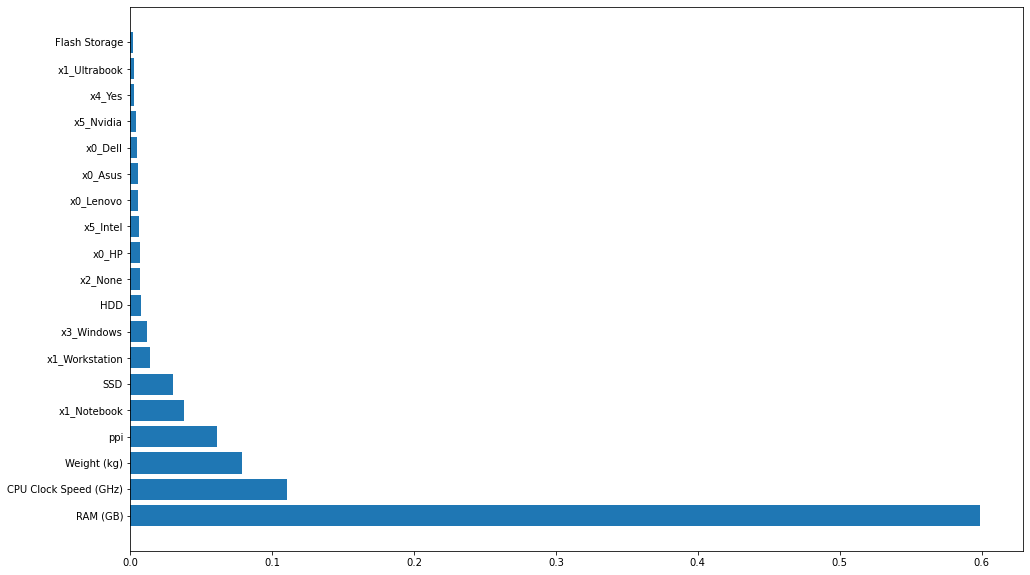

In [1531]:
plt.figure(figsize=(16,10))

plt.barh(importance_df['feature_names'], importance_df['importance'])

plt.show()

# ML Modelling

In [1537]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Baseline Regressor
Used sklearn's Dummy Regressor to obtain an R^2 of -0.0016, which is normal for a dummy model as it ignores all input variables to predict the output variables.

Having an negative R^2 is also actually possible according to sk-learn's documentation as "the model can be arbitrarily worse".

In [1533]:
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)

In [1534]:
r2 = r2_score(y_test, y_pred)
print(f"Dummy Regressor R^2: {r2}")

Dummy Regressor R^2: -0.0016682325811376852


## Model Selection

In [1535]:
# Testing different models
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Bagging Regressor': BaggingRegressor(random_state=42)
}

cv5_mse_scores = []
cv5_r2_scores = []
test_mse = []
test_r2 = []


for name in models:
  model = models[name]
  model.fit(X_train, y_train)
  cv5_mse_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))
  cv5_r2_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='r2')) * 100)
  
  model.fit(X_train, y_train) # fit and then test baseline models on the test set
  y_pred = model.predict(X_test)

  test_mse.append(mean_squared_error(y_test, y_pred))
  test_r2.append(r2_score(y_test, y_pred))


model_list = []
for index, (key, value) in enumerate(models.items()):
  model_list.append(key)

results = {'Model': model_list, '5-fold cv Negative MSE': cv5_mse_scores, 'test_mse': test_mse, '5_fold cv R^2 (%)': cv5_r2_scores, 'test_r2': test_r2}

results_df = pd.DataFrame(results)

In [1536]:
results_df

,Model,5-fold cv Negative MSE,test_mse,5_fold cv R^2 (%),test_r2
0,Linear Regression,-0.094927,0.094683,75.226097,0.758440
1,K-Nearest Neighbors,-0.001873,0.001702,99.511219,0.995658
2,Elastic Net,-0.175617,0.175613,54.175750,0.551968
3,Decision Tree,-0.001229,0.001589,99.679399,0.995947
4,Random Forest,-0.001243,0.001584,99.675600,0.995959
5,ExtraTreesRegressor,-0.001229,0.001589,99.679399,0.995947
6,AdaBoost,-0.072906,0.072704,80.981059,0.814515
7,Gradient Boosting,-0.038590,0.039369,89.932129,0.899559
8,Bagging Regressor,-0.001281,0.001602,99.665730,0.995914


## Decision Tree Regressor
Decision Tree, Random Forest and K-Nearest Neighbors all performed very well without any hyperparameter tuning, achieving R^2 scores of above 99.4% and Negative Mean Squared Error of above -0.002.

Decision Tree performed the best out of all 3 models, hence we will try to fit the Decision Tree Regressor on the test set

The Decision Tree performed well even on the test set, achieving a R^2 score of 99.58% and a MSE of 0.00166, which is very close to what we got on the 3 fold CV, showing no signs of overfitting

In [1441]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [1442]:
print(f"R^2 score: {r2 * 100}%")
print(f"Mean Squared Error: {mse}")

R^2 score: 99.59467169248947%
Mean Squared Error: 0.0015887453582696417


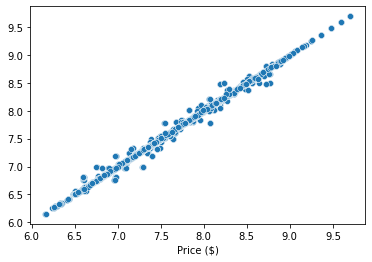

In [1443]:
sns.scatterplot(x=y_test, y=y_pred)
plt.show()

## Learning Curve
The learning curve shows that the model is not showing either high bias or high variance as the validation and training curves convereged at a single point forming a horizontal asymptote

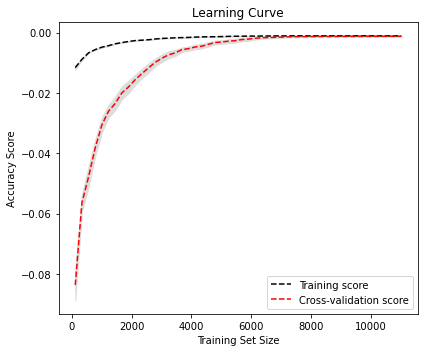

In [1429]:
train_sizes, train_scores,test_scores = learning_curve(DecisionTreeRegressor(), X_train, y_train, cv=10, scoring='neg_mean_squared_error',
                                                       n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50)
                                                       )

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(6,5))

plt.plot(train_sizes, train_mean, '--', color="black", label="Training score")
plt.plot(train_sizes, test_mean, '--', color="red", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

## Feature Importance
From the table, the model considers if the laptop has a Nvidia GPU as most important, followed by its ppi and SSD. 

In [1424]:
pd.DataFrame(list(zip(X_train.columns, tuned_dt.feature_importances_)), columns = ['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
18,x5_Nvidia,0.212989
6,ppi,0.182471
4,SSD,0.148652
1,Weight (kg),0.096040
5,CPU Clock Speed (GHz),0.084903
0,RAM (GB),0.060364
11,x1_Notebook,0.038130
15,x3_Windows,0.031286
14,x2_None,0.028476
12,x1_Ultrabook,0.028344
